# Quantum chaos!

The kicked rotator:

$$ H(t) = \frac{J^2}{2 I_0} + K \frac{I_0}{\tau_0} \cos \theta \sum_n \delta(t - n \tau_0) $$



leads either to the classical standard map, or to the quantum map at $\hbar_{eff} = \frac{2 \pi}{M}$.

Examples of quantum kicked top-like evolution can be found in

* particle dynamics in accelerators (and reactors?)
* microwave ionization
* electron magneto-transport in resonant tunneling diodes
* cold atoms in magneto-optical traps
* superconducting nanodevices - normal metal ring surrounded by superconductor?
* [superconducting Josephson junction - J.M. Martinis, Google Labs, 2016](https://www.nature.com/articles/nphys3830)

$$ F(t) = F^t = \left[\exp\left(\frac{-i p^2}{2 \hbar_{eff}}\right) \exp \left(\frac{-i K \cos(x)}{\hbar_{eff}}\right) \right]^t $$

for M even (at resonance), momentum-dependent evolution is periodic as well:
$$ \exp(\frac{-i p^2}{2 \hbar_{eff}}) = \exp\left(-i \frac{\hbar}{2} m^2 - i 2 \pi m - i \frac{(2 \pi)^2}{2 \hbar_{eff}} \right)$$

The $p^2$ operator is diagonal in momenta and $\cos(x)$ is diagonal in positions, so it make sense for us to go to the momentum basis to apply it

One step of quantum evolution:

1. apply position operator
2. DFT
3. apply momentum operator
4. DFT

psi, x and p could be represented as numpy vectors, while the DFT can be represented as a matrix - but it's much more efficient to use FFT - $O(M \log M)$ rather than $O(M^2)$.

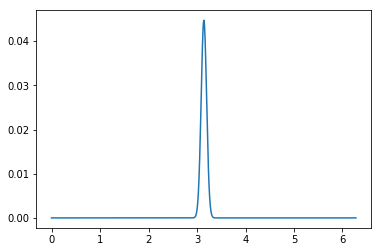

1.0

In [1]:
import numpy as np
from scipy import fft, ifft
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm_notebook

Npoints = 200 #TODO
K = 0.1
M = 1000
Nframes = 3000
hbar = 2 * np.pi / M # TODO - M even?
# hbar = 1
xmax = 2 * np.pi
pmax = 2 * np.pi
wavepacket_x_center = xmax / 2
wavepacket_p_center = 0.1

x = np.arange(M) * 2 * np.pi / M
p = np.arange(M) * 2 * np.pi / M
dx = x[1] - x[0]
# p = np.linspace(0, pmax, Npoints)
Vn = np.exp(-1j * K * np.cos(x) / hbar)
Pm = np.exp(-1j * p**2 / (2 * hbar))

def initial_condition(wavepacket_x_center, wavepacket_p_center):
    psi_0 = np.exp(1j * wavepacket_p_center * x / hbar)
    psi_0 *= np.exp(-(x - wavepacket_x_center)**2 / (2 * hbar))
    psi_0 /= np.linalg.norm(psi_0)
    return psi_0

psi_0 = initial_condition(wavepacket_x_center, wavepacket_p_center)

plt.plot(x, np.abs(psi_0)**2)
plt.show()
np.linalg.norm(psi_0)

1.0

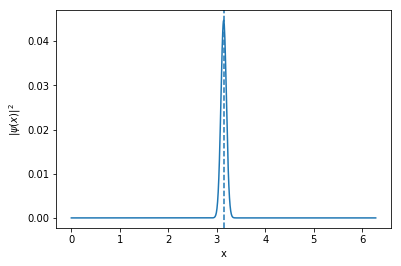

In [9]:
def initial_condition_mirror(x, wavepacket_x_center, p, wavepacket_p_center, d = 4):
    D = np.linspace(-d, d, 2*d+1).reshape(1, 2*d+1)
    psi_0 = np.exp(1j * wavepacket_p_center * x / hbar)
    mirror_images = np.exp(-(x[:, np.newaxis] - wavepacket_x_center + 2 * np.pi * D)**2 / (2 * hbar))
#     plt.plot(mirror_images)
    psi_0 = psi_0 * mirror_images.sum(axis=1)
    psi_0 /= np.linalg.norm(psi_0)
    return psi_0


psi_0 = initial_condition_mirror(x, wavepacket_x_center, p, wavepacket_p_center)

plt.plot(x, np.abs(psi_0)**2)
plt.axvline(wavepacket_x_center, linestyle="--")
plt.ylabel(r"$|\psi(x)|^2$")
plt.xlabel("x");
np.linalg.norm(psi_0)

0.9999999999999999

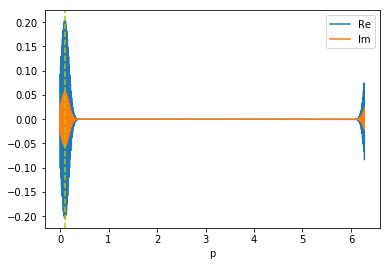

In [10]:
psi_0_p = fft(psi_0) / np.sqrt(M) ## / np.sqrt(2 * np.pi)
plt.plot(p, psi_0_p.real, label="Re")
plt.plot(p, psi_0_p.imag, label="Im")
plt.xlabel("p")
plt.axvline(wavepacket_p_center, linestyle="--", color="y")
plt.legend()
np.linalg.norm(psi_0_p)

# Task 2

In [11]:
def plot(x, y, *args, **kwargs):
    plt.plot(x, np.abs(y)**2, *args, **kwargs)

In [16]:
def iterate(psi, Vn, Pm):
    psi_V = Vn * psi
    psi_V_fft = fft(psi_V) / np.sqrt(M) # np.sqrt(2 * np.pi) # normalizacja jest tak naprawdę bezużyteczna
    psi_V_fft_p = Pm * psi_V_fft 
    psi_new = ifft(psi_V_fft_p) * np.sqrt(M) # * np.sqrt(M)# / np.sqrt(2*np.pi)
    return psi_new

psi = psi_0
frames = []
for i in tqdm_notebook(range(Nframes)):
    normed = np.abs(psi)**2
    frames.append(normed)
#     plot(x, normed, label=i)
    psi = iterate(psi, Vn, Pm)
# plt.legend()

In [13]:
fig, ax = plt.subplots()
line, = ax.plot(x, np.zeros_like(x))
plt.close()

def animate(y):
    line.set_ydata(y)
    return line,
    

anim = FuncAnimation(fig, animate, frames, interval=30)
from IPython.display import HTML
HTML(anim.to_html5_video())

In [21]:
# for K in [0.6, 2.1, 5.2]:
def distribution(K,
                 Niterations = 4,
                 M = 100,
                 Nframes=1000,
                 wavepacket_x_center = 0.5,
                 wavepacket_p_center = 0.1,
                 xmax = 2*np.pi,
                 pmax=2*np.pi,
                ):
    hbar = 2 * np.pi / M # TODO - M even?
    # hbar = 1
#     wavepacket_x_center *= xmax
#     wavepacket_p_center *= pmax

    x = np.arange(M) * 2 * np.pi / M
    p = np.arange(M) * 2 * np.pi / M
    dx = x[1] - x[0]
    
    Vn = np.exp(-1j * K * np.cos(x) / hbar)
    Pm = np.exp(-1j * p**2 / (2 * hbar))
    
    psi = initial_condition_mirror(x, wavepacket_x_center,
                                   p, wavepacket_p_center)
    
    psi_G_list = [initial_condition_mirror(x, 2 * np.pi * n0 / M, p, 0) for n0 in range(M)]
    
    Qdists = []
    for i in tqdm_notebook(range(Niterations)):
        psi = iterate(psi, Vn, Pm)
        Qdist = np.zeros((M, M), dtype=complex)  
        for n0 in range(M):
            Qdist[:,n0] = fft(np.conj(psi_G_list[n0])*psi)
        Qdists.append(Qdist)
    
    X, Y = np.meshgrid(x, p)
    fig, ax = plt.subplots()
    mesh = ax.pcolor(X, Y, np.abs(Qdists[0]))
    plt.colorbar(mesh)
    title = ax.set_title(f"K = {K}, x0 = {wavepacket_x_center:.2f}, p0 = {wavepacket_p_center:.2f}, iteration {0}")
    plt.close()

    def animate(i):
        mesh.set_array(np.abs(Qdists[i]).ravel())
        title.set_text(f"K = {K}, x0 = {wavepacket_x_center:.2f}, p0 = {wavepacket_p_center:.2f}, iteration {i}")
        return mesh, title

    anim = FuncAnimation(fig, animate, Niterations, interval=500)
    from IPython.display import HTML
    return HTML(anim.to_html5_video())

for K in [0,
          1.6,
          2.1,
          5.2,
         ]:
    display(distribution(K,
                         Niterations = 30,
                         wavepacket_x_center=1.5,
                         wavepacket_p_center=0.3,
                        ))

In [22]:
for K in [0,
          1.6,
          2.1,
          5.2,
         ]:
    display(distribution(K,
                         Niterations = 30,
                         M = 1000,
                         wavepacket_x_center=1.5,
                         wavepacket_p_center=0.3,
                        ))

Husimi distribution - we decompose the gaussian into two parts - one depending on the initial position and one depending on the momentum

use a single fft

To calculate exponential sensitivity we check "fidelity":

$$F(t) = | < \psi_{pert}(t) | \psi_0(t)>|^2 \propto \exp(-\lambda t)$$

[Jalabert and Pastawski in PRL '01](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.86.2490) claim it's independent of the *(small)* perturbation for a large parameter range at $\hbar \to 0$ (in the classical limit)